# **Mount the Google drive**
The trained models are uploaded to the google drive and inorder to load them the drive is mounted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/HelmetDetection

/content/drive/MyDrive/HelmetDetection


# **Import the required packages**

In [ ]:
# clone Tensorflow object detection api
!git clone https://github.com/tensorflow/models

In [ ]:
# Run to install proto buffers for object detection api
!apt-get update 
!apt-get install -y -qq protobuf-compiler python-pil python-lxml

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/HelmetDetection/models/research/slim')
!pip install tf_slim

In [ ]:
%cd /content/drive/MyDrive/HelmetDetection/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/drive/MyDrive/HelmetDetection/models/research


In [ ]:
# Import packages
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
from google.colab.patches import cv2_imshow

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
pwd

'/content/drive/MyDrive/HelmetDetection/models/research'

# **Configure the paths to trained models**
A Faster RCNN model is trained to detect motorcyclists in a given image.

A YOLO model is trained to detect helmet in the given image of motorcyclist.



In [ ]:
CWD_PATH = '/content/drive/MyDrive/HelmetDetection/'

MODEL_RCNN = 'rcnn'

MODEL_YOLO='yolo'

# Path to frozen detection graph .pb file, which contains the model that is used
# for rcnn object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_RCNN,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_RCNN,'label_map.pbtxt')

# Path to yolo files
configPath=os.path.join(CWD_PATH,MODEL_YOLO,'yolov3_custom.cfg')   
weightsPath=os.path.join(CWD_PATH,MODEL_YOLO,'yolov3_custom_4000.weights')
labelsPath=os.path.join(CWD_PATH,MODEL_YOLO,'obj.names')


# **Configure the input and output paths**

Images of Motorcyclists without helmet are stored in the Output folder.


In [ ]:
# Path to input image
IMAGE_NAME = 'input/images/sample.jpeg'

# Path to input video 
VIDEO_NAME = 'input/videos/clip.mp4'

OUTPUT_FOLDER='output/'

# Path to output
PATH_TO_OUTPUT = os.path.join(CWD_PATH, OUTPUT_FOLDER,'/images')
VIDEO_OUTPUT = os.path.join(CWD_PATH, OUTPUT_FOLDER,'output_clip.mp4')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Path to video
PATH_TO_VIDEO = os.path.join(CWD_PATH,VIDEO_NAME)

# **Configure Faster RCNN Model**

In [ ]:

# Load the label map.
# Label maps map indices to category names
# Here we use internal utility functions
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    sess = tf.compat.v1.Session(graph=detection_graph)
    
# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# **Configure YOLO Model**

In [ ]:
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
LABELS = open(labelsPath).read().strip().split("\n")

# **Detection Of Motorcyclists Without Helmet From Input Image**
The two models are integrated to detect the motorcyclists without helmet from the input image and the images of riders without helmet are stored in the output folder

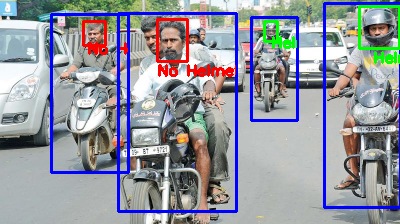

In [ ]:
image = cv2.imread(PATH_TO_IMAGE)
image = cv2.resize(image,None,fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

#getting the normalized coordinates of boxes
normalizedBoxes = np.squeeze(boxes)
normalizedScores = np.squeeze(scores)
normalizedClasses = np.squeeze(classes)

#set a min thresh score, say 0.8
min_score_thresh = 0.8
detectedBoxes = normalizedBoxes[normalizedScores > min_score_thresh]
detectedClasses = normalizedClasses[normalizedScores > min_score_thresh]

#get image size
im_height,im_width, _=image.shape
size=(im_width, im_height)

#get  original coordinates of bike riders in image 
final_boxes = []
for i in range(len(detectedBoxes)):
    ymin, xmin, ymax, xmax = detectedBoxes[i]
    final_boxes.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])

j=0
for [left,right,top,bottom] in final_boxes:
    
    l=int(round(left))
    r=int(round(right))
    t=int(round(top))
    b=int(round(bottom))
    croppedImage=image[t:b,l:r]  # Extract each bike rider
    
    cv2.rectangle(image, (l,t), (r,b), (255,0,0), 2)
    
    # perform padding to cropped image 
    rows = croppedImage.shape[0]
    cols = croppedImage.shape[1]
    padding=0
    if rows > cols:
        padding = int((rows-cols) / 2)
        paddedImg=cv2.copyMakeBorder(croppedImage, 0, 0, padding, padding,  cv2.BORDER_CONSTANT, (0, 0, 0))
    else:
        paddedImg=croppedImage
    
    # image preprocessing for yolo model
    (H, W) = paddedImg.shape[:2]
    blob = cv2.dnn.blobFromImage(paddedImg, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    
    # run yolo model
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Initializing for getting box coordinates, confidences, classid
    boxesH = []
    confidencesH = []
    classIDsH = []
    thresholdH = 0.15

    # getting coordinates of output predictions and performing NMS
    for output in layerOutputs:
        for detection in output:
            confidenceOfEachClass = detection[5:]
            classIDH = np.argmax(confidenceOfEachClass)    # get class with max confidence
            confidenceH = confidenceOfEachClass[classIDH]  # get the max confidence
            if confidenceH > thresholdH:
                boxH = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, widthH, heightH) = boxH.astype("int")           
                x = int(centerX - (widthH / 2))
                y = int(centerY - (heightH / 2))    
                boxesH.append([x, y, int(widthH), int(heightH)])
                confidencesH.append(float(confidenceH))
                classIDsH.append(classIDH)
    idxs = cv2.dnn.NMSBoxes(boxesH, confidencesH, thresholdH, 0.1)
   
    # bounding boxes for helmet- no helmet
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxesH[i][0], boxesH[i][1])
            (w, h) = (boxesH[i][2], boxesH[i][3])
            if LABELS[classIDsH[i]] == 'Helmet':            
                color = (0, 255, 0)
                cv2.rectangle(croppedImage, (x-padding, y), (x + w-padding, y + h), color, 2)
                text = "{}".format(LABELS[classIDsH[i]])
                cv2.putText(croppedImage, text, (x//2, y+ 4*h//3),                     
                cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
            if (LABELS[classIDsH[i]] == 'No Helmet'):
                # store images with no helmet
                name=IMAGE_NAME.split(".")[0].split('/')[-1]
                j+=1
                cv2.imwrite( PATH_TO_OUTPUT + '{}.jpg'.format(name+str(j)),croppedImage) 
          
                # draw bounding box
                color = (0, 0, 255)
                cv2.rectangle(croppedImage, (x-padding, y), (x + w-padding, y + h), color, 2)
                text = "{}".format(LABELS[classIDsH[i]])
                cv2.putText(croppedImage, text, (x//2, y + 4* h//3),      
                cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2) 
                
              
cv2_imshow(image)

# **Detection Of Motorcyclists Without Helmet From Input Video Stream**
The two models are integrated to detect the motorcyclists without helmet from the input video stream and the images of riders without helmet are stored in the output folder, along with the resulting video stream

In [ ]:

video = cv2.VideoCapture(PATH_TO_VIDEO)

images=[]
f=0
while(video.isOpened()):
  if f%3!=0:
    ret,image = video.read()
    f+=1
    continue
  ret,image = video.read()
  if ret == True: 
    image=cv2.resize(image,None,fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    image_expanded = np.expand_dims(image, axis=0)

    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})


    #getting the normalized coordinates of boxes
    normalizedBoxes = np.squeeze(boxes)
    normalizedScores = np.squeeze(scores)
    normalizedClasses = np.squeeze(classes)

    #set a min thresh score, say 0.8
    min_score_thresh = 0.8
    detectedBoxes = normalizedBoxes[normalizedScores > min_score_thresh]
    detectedClasses= normalizedClasses[normalizedScores > min_score_thresh]

    #get image size
    im_height,im_width, _=image.shape
    size=(im_width, im_height)

    #get coordinates of bike riders in image
    final_boxes = []
    for i in range(len(detectedBoxes)):
        ymin, xmin, ymax, xmax = detectedBoxes[i]
        final_boxes.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])

    j=0
    for [left,right,top,bottom] in final_boxes:        
        l=int(round(left))
        r=int(round(right))
        t=int(round(top))
        b=int(round(bottom))
        croppedImage=image[t:b,l:r]  # Extract each bike rider
        
        cv2.rectangle(image, (l,t), (r,b), (255,0,0), 2)
        
        # perform padding to cropped image
        rows = croppedImage.shape[0]
        cols = croppedImage.shape[1]
        padding=0
        if rows > cols:
            padding = int((rows-cols) / 2)
            paddedImg=cv2.copyMakeBorder(croppedImage, 0,0,padding, padding,  cv2.BORDER_CONSTANT, (0, 0, 0))
        else:
            paddedImg=croppedImage
        
        # image preprocessing for yolo model
        (H, W) = paddedImg.shape[:2]
        blob = cv2.dnn.blobFromImage(paddedImg, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        
        # run yolo model
        net.setInput(blob)
        layerOutputs = net.forward(ln)

        # Initializing for getting box coordinates, confidences, classid
        boxesH = []
        confidencesH = []
        classIDsH = []
        thresholdH = 0.15

        # getting coordinates of output predictions and performing NMS
        for output in layerOutputs:
            for detection in output:
                confidenceOfEachClass = detection[5:]
                classIDH = np.argmax(confidenceOfEachClass)    # get class with max confidence
                confidenceH = confidenceOfEachClass[classIDH]  # get the max confidence
                if confidenceH > thresholdH:          
                    boxH = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, widthH, heightH) = boxH.astype("int")           
                    x = int(centerX - (widthH / 2))
                    y = int(centerY - (heightH / 2))    
                    boxesH.append([x, y, int(widthH), int(heightH)])
                    confidencesH.append(float(confidenceH))
                    classIDsH.append(classIDH)
        idxs = cv2.dnn.NMSBoxes(boxesH, confidencesH, thresholdH, 0.1)

        # bounding boxes for helmet- no helmet
        if len(idxs) > 0:
            for i in idxs.flatten():
                (x, y) = (boxesH[i][0], boxesH[i][1])
                (w, h) = (boxesH[i][2], boxesH[i][3])
                if LABELS[classIDsH[i]] == 'Helmet':            
                    color = (0, 255, 0)
                    cv2.rectangle(croppedImage, (x-padding, y), (x + w-padding, y + h), color, 2)
                    text = "{}".format(LABELS[classIDsH[i]])
                    cv2.putText(croppedImage, text, (x//2, y+ 4*h//3),                     
                    cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
                if (LABELS[classIDsH[i]] == 'No Helmet'):
                    #store images with no helmet
                    name=VIDEO_NAME.split(".")[0].split('/')[-1]+"_"+str(f)+"_"
                    j+=1
                    cv2.imwrite(PATH_TO_OUTPUT + '{}.jpg'.format(name+str(j)),croppedImage)
                    # draw bounding boxes
                    color = (0, 0, 255)
                    cv2.rectangle(croppedImage, (x-padding, y), (x + w-padding, y + h), color, 2)
                    text = "{}".format(LABELS[classIDsH[i]])
                    cv2.putText(croppedImage, text, (x//2, y + 4* h//3),      
                    cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2) 
        images.append(image)   
    f+=1
    #cv2_imshow(image)
  else:
    break
video.release()


out = cv2.VideoWriter(VIDEO_OUTPUT,cv2.VideoWriter_fourcc(*'mp4v'), 15, size)
for i in range(len(images)):
    out.write(images[i])
out.release()